# Regression and ANOVA Test

## Set SQL environment

In [138]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import pyodbc
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols



#Set the environment to get the table from the databse in SQL Server

# Defining our connection variables
driver = 'FreeTDS'
server = 'localhost'  # change this to your db’s IP address
port = '1433'
database = 'Suicide_Project' # change this to the name of your db
username = 'sa' # replace with your username
password = '' # replace with your password
version  = '7.3'

#Create string to connect
mssql_string = 'DRIVER={'+driver+'};SERVER='+server+';PORT='+port+';DATABASE='+database+';UID='+username+';PWD='+password+';TDS_Version='+version+';'

conn = pyodbc.connect(mssql_string)

engine = create_engine('mssql+pyodbc://{}:{}@{}:{}/{}?driver={}'.format(username, password, server, port, database, driver))


## Define outlier deletion function

In [139]:
#Detect and deletes outliers in the scores using the Inter Quartile Range
def delete_outliers (var):
    Q1 = np.percentile(suicide_rate[var], 25, interpolation = 'midpoint')
    Q3 = np.percentile(suicide_rate[var], 75, interpolation = 'midpoint')
    IQR = Q3-Q1 
    #Above Upper Bound
    upper = suicide_rate.index[suicide_rate[var] >= (Q3 + 2*IQR)]
    country_upper = suicide_rate.iloc[upper]
    #Below Lower Bound
    lower = suicide_rate.index[suicide_rate[var] <= (Q1 - 2*IQR)]
    country_lower = suicide_rate.iloc[lower]
    #Drops outliers
    suicide_rate.drop(upper, inplace = True)
    suicide_rate.drop(lower, inplace = True)
    return country_upper, country_lower

## Get Table with the suicide rate and GDP data from SQL database

In [140]:
suicide_rate = pd.read_sql_query(
    '''SELECT  *
    FROM SuicideGDP''', 
con=engine)

suicide_rate

,Country,SuicideRate,GDP2019
0,Antigua and Barbuda,0.39,21521.885051
1,Barbados,0.62,16051.255812
2,Grenada,0.66,17231.512230
3,Sao Tome and Principe,1.48,4089.156666
4,Jordan,1.64,10253.817450
...,...,...,...
169,Micronesia (Federated States of),28.21,3544.004820
170,Lao People's Democratic Republic,5.43,7775.131876
171,Democratic Republic of the Congo,6.70,4022.748814
172,Saint Lucia,7.88,15653.299802


## Create a scatterplot to see if there is a relationship in the data

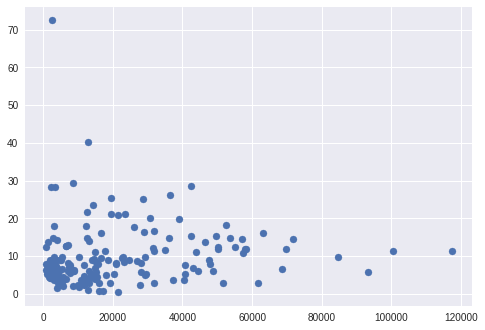

In [141]:
plt.scatter(suicide_rate['GDP2019'] , suicide_rate['SuicideRate'])

Delete outliers that distort the data, first by suicide rate, then by GDP

In [142]:
delete_outliers('SuicideRate')

(                              Country  SuicideRate       GDP2019
 65                           Kiribati        28.29   2341.192329
 66                           Eswatini        29.40   8725.162793
 91                             Guyana        40.28  12777.164992
 130                           Lesotho        72.44   2677.436314
 157                 Republic of Korea        28.57  42487.041947
 169  Micronesia (Federated States of)        28.21   3544.004820,
 Empty DataFrame
 Columns: [Country, SuicideRate, GDP2019]
 Index: [])

In [143]:
delete_outliers('GDP2019')

(        Country  SuicideRate        GDP2019
 8     Singapore        11.21  100581.158025
 9    Luxembourg        11.27  117245.278889
 106     Senegal         6.00    3388.946311
 152    Bulgaria         9.73   22957.400134,
 Empty DataFrame
 Columns: [Country, SuicideRate, GDP2019]
 Index: [])

Create a new scatterplot without the outliers

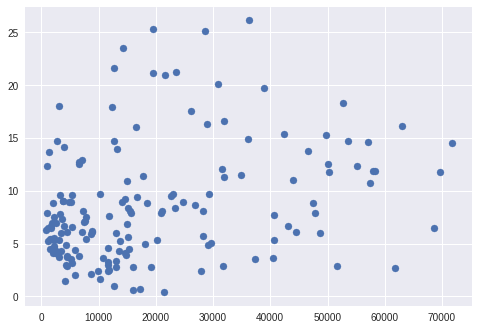

In [144]:
plt.scatter(suicide_rate['GDP2019'] , suicide_rate['SuicideRate'])

We don't see a clear relationship in the data, but we run a regression to confirm it.

## Run the regression with the GDP as the explanatory variable and the suicide rate as the dependent one

/home/gabriel/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


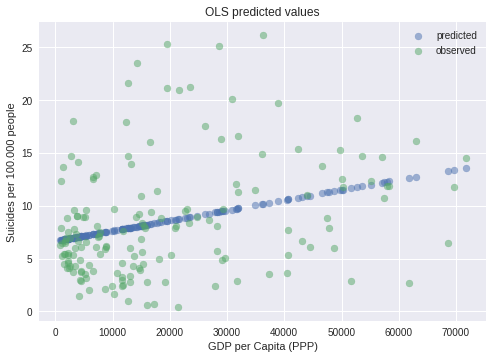

                            OLS Regression Results                            
Dep. Variable:            SuicideRate   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     17.72
Date:                Wed, 09 Feb 2022   Prob (F-statistic):           4.23e-05
Time:                        22:55:38   Log-Likelihood:                -502.47
No. Observations:                 164   AIC:                             1009.
Df Residuals:                     162   BIC:                             1015.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6589      0.600     11.096      0.0

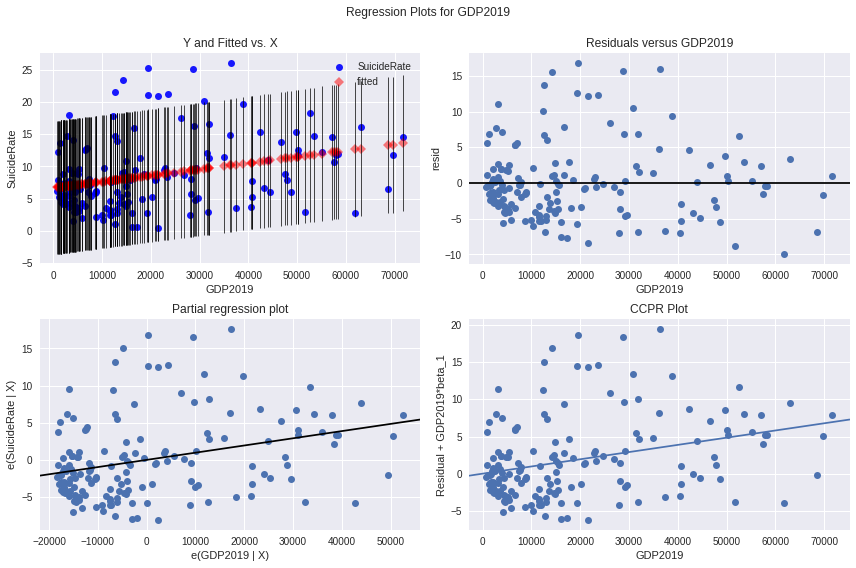

In [145]:
x = suicide_rate[['GDP2019']] #Independent Variable, explains the y

x = sm.add_constant(x)

y = suicide_rate['SuicideRate'] #Dependent Variable, we want to explain it



model = sm.OLS(y, x).fit()


# Plot a graph showing the regression

plt.style.use('seaborn')

# Plot predicted values

predictions = model.predict(x) # make the predictions by the model
fix, ax = plt.subplots()
ax.scatter(suicide_rate['GDP2019'], predictions, alpha=0.5,
        label='predicted')

# Plot observed values

ax.scatter(suicide_rate['GDP2019'], suicide_rate['SuicideRate'], alpha=0.5,
        label='observed')

#Configure and show graph

ax.legend()
ax.set_title('OLS predicted values')
ax.set_xlabel('GDP per Capita (PPP)')
ax.set_ylabel('Suicides per 100.000 people')
plt.show()

#Define figure size
fig = plt.figure(figsize=(12,8))

#Produce regression plots
fig = sm.graphics.plot_regress_exog(model,'GDP2019' , fig=fig)

# Print out the statistics
print(model.summary())

There seems to be a small correlation on the data, it is big enough to not be able to reject the hypothesis that there is a relationship. Nevertheless, as we have an extemely small r² value, we can't realy affirm or deny that the GDP per capita influences the suicide rate.

## Get Table with suicide rate and sunlight data from SQL database

In [146]:
suicide_rate = pd.read_sql_query(
    '''SELECT  *
    FROM SuicideSunlight''', 
con=engine)

suicide_rate

,Country,SuicideRate,SunshineLevel
0,Austria,14.60,Low
1,Belarus,21.20,Low
2,Belgium,18.29,Low
3,Bosnia and Herzegovina,10.93,Low
4,Colombia,3.90,Low
...,...,...,...
102,United Arab Emirates,6.43,High
103,Zambia,7.29,High
104,Zimbabwe,14.12,High
105,Cabo Verde,12.93,Low


Delete the outliers in the table

In [147]:
delete_outliers('SuicideRate')

(              Country  SuicideRate SunshineLevel
 37             Guyana        40.28    Medium-Low
 39  Republic of Korea        28.57    Medium-Low,
 Empty DataFrame
 Columns: [Country, SuicideRate, SunshineLevel]
 Index: [])

## Generate a boxplot to see the data distribution by sunlight level

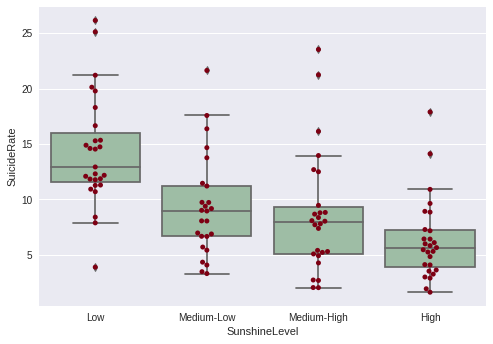

In [148]:
import seaborn as sns
ax = sns.boxplot(x='SunshineLevel', y='SuicideRate', data=suicide_rate, color='#99c2a2')
ax = sns.swarmplot(x='SunshineLevel', y='SuicideRate', data=suicide_rate, color='#7d0013')
plt.show()

We can see a clear relation between the sunlight level and the suicide rate

## Run an ANOVA test to confirm there is a relationship between the categories and the suicide rate

In [149]:
model = ols('SuicideRate ~ C(SunshineLevel)', data=suicide_rate).fit() # Ordinary Least Squares (OLS) model

anova_table = sm.stats.anova_lm(model, typ=2)

anova_table

,sum_sq,df,F,PR(>F)
C(SunshineLevel),917.709601,3.0,13.800544,1.302346e-07
Residual,2238.768451,101.0,NaN,NaN


We can say there is a non-irrelevant relationship between categories an data

## Create a bar plot to see a simple visualization of the relationship

In [150]:
#Get all age groups
sunshine_level = suicide_rate['SunshineLevel'].drop_duplicates()

#Sort them from youngest to oldest and make a list
sunshine_level = sunshine_level.tolist()

#Create container dataframe
suicide_sunlight = pd.DataFrame(columns = ['Sunshine Level','Mean Suicide Rate'])

#Append the suicide rate by age group
for level in sunshine_level :
    series = suicide_rate.loc[suicide_rate['SunshineLevel'] == level, 'SuicideRate']
    age = level.replace(' years', '')
    mean = series.mean()
    row = pd.Series([level,mean], index=suicide_sunlight.columns)
    suicide_sunlight = suicide_sunlight.append(row, ignore_index=True)

suicide_sunlight

,Sunshine Level,Mean Suicide Rate
0,Low,14.299630
1,Medium-Low,9.297200
2,Medium-High,8.578846
3,High,6.310741


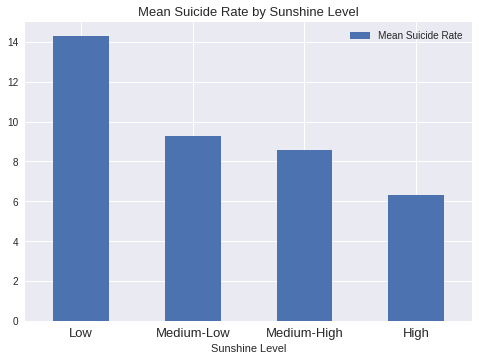

In [136]:
ax = suicide_sunlight.plot.bar(x='Sunshine Level', y='Mean Suicide Rate', rot=0)

ax.set_title('Mean Suicide Rate by Sunshine Level', fontsize = 13)

plt.xticks(fontsize = 13)

plt.show()